In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Activation Function 

In [19]:
def sigmoid(z):

    return 1/(1+np.exp(-z))

# Backpropagation algorithm

In [20]:
class NeuralNetwork:
    def __init__(self, 
                 n_hidden=(100,),
                 learning_rate=0.1,
                 epochs=10,
                 threshold=0.5):
        # a list containing the number of nodes in 
        # each hidden layer.
        self.n_hidden = n_hidden
        
        # the input layer, output layer, and hidden layers.
        self.n_layers = len(n_hidden) + 2
        
        # gradient descent parameters
        self.learning_rate = float(learning_rate)
        self.epochs = int(epochs)
        self.threshold = float(threshold)
        self.monitoring={"mean_squared_error":[], "accuracy":[]}

    def LayerWeight_initialization(self):
        # a small amount of randomization is necessary to
        # break symmetry; otherwise all hidden layers would
        # get updated in lockstep.
        if not self.n_hidden:
            layer_sizes = [ (self.n_output, self.n_input+1) ]
        else:
            layer_sizes = [ (self.n_hidden[0], self.n_input+1) ]
            previous_size = self.n_hidden[0]

            for size in self.n_hidden[1:]:
                layer_sizes.append( (size, previous_size+1) )
                previous_size = size

            layer_sizes.append( (self.n_output, previous_size+1) )
        
        self.layers = [[np.random.normal(0, 0.1, size=layer_size),np.zeros_like(np.random.normal(0, 0.1, size=layer_size)) ,sigmoid]for layer_size in layer_sizes]  
        self.v=0
    def _get_batch(self, X, y, batch_size=10):
        indexes = np.random.randint(len(X), size=batch_size)
        return X[indexes,:], y[indexes,:]

    def fit(self,X,y,minibatch_size=10,momentum=False,momentum_Factor=0.9):
        self.n_input = X.shape[1]        
        self.n_output = y.shape[1]
        self.LayerWeight_initialization()
        
        # fitting iterations
        for iteration in range(self.epochs):
            X,y=shuffle(X,y)
            
            # Randomize data point
        #    for i in range(10)
                # X_batch, y_batch = self._get_batch(X, y)
            self.forward_propagation(X)
            self.back_propagation(y,momentum,momentum_Factor)
        monitoring_df=pd.DataFrame(self.monitoring)
    
        return  monitoring_df
    def shuffle(self,X,y):
        data=np.concatenate([X, y],axis=1)
        col=data.shape[1]
        output_col=y.shape[1]
        X=data[:,:col-output_col]
        y=data[:,col-output_col:col]
        return X,y   
    def predict(self, X):
        y_class_probabilities = self.predict_proba(X)

        return np.where(y_class_probabilities[:,:] < self.threshold, 0, 1)
    
    def predict_proba(self, X):
        self.forward_propagation(X)
        return self._activations[-1]   

    def monitor(self,y_hat,y):
        mse=self.mean_squared_error(y_hat,y)
        acc=self.accuracy(y_hat,y)
        self.monitoring["mean_squared_error"].append(mse)
        self.monitoring["accuracy"].append(acc)
    
    def forward_propagation(self, X):
        # we will store the activations calculated at each layer
        # because these can be used to efficiently calculate
        # gradients during backpropagation.
        self._activations = []
        
        # initialize the activation with the given data
        activation = X  
        
        # forward propagation through all layers
        for W, v,activation_function in self.layers:
            bias = np.ones( (activation.shape[0], 1) )
            activation = np.hstack([bias, activation])
            self._activations.append(activation)
            activation = activation_function(activation @ W.T)    
        
        # the final activation layer does not have a bias node added.
        self._activations.append(activation)  

    def back_propagation(self, y,momentum,momentum_Factor):
        # this function relies on self._activations calculated
        # by self.forward_propagation()

        N = y.shape[0]
        
        # the final prediction is simply activation of the final layer.
        y_hat = self._activations[-1]
        
        # this first error term is based on the gradient of the loss function:
        # log-loss in our case. Subsequently, error terms will be based on the 
        # gradient of the sigmoid function. 
        error = y_hat - y

        self.monitor(y_hat,y)
        # we can see where the backpropagation algorithm gets its name: we
        # start at the last layer and work backwards, propagating the error
        # term from each layer to the previous one.
        for layer in range(self.n_layers-2, -1, -1):
            # calculate the update (delta) for the weight matrix
            a = self._activations[layer]
            
            delta = (error.T @ a) / N
            
            # every layer except the output layer has a bias node added.
            if layer != self.n_layers-2:
                delta = delta[1:, :]
            
            # propogate the error term back to the previous layer
            W = self.layers[layer][0]
            v=self.layers[layer][1]
            if layer > 0:
                
                # every layer except the output layer has a bias node added.
                if layer != self.n_layers-2:
                    error = error[:, 1:]
                    
                # the a(1-a) is the gradient of the sigmoid function.
                error = (error @ W) * (a * (1-a))
            if momentum== True:
                # update weights
                
                v=momentum_Factor *v+self.learning_rate*delta
                W -=  v
               
            elif momentum ==False:
                W -= self.learning_rate * delta

        

    def mean_squared_error(self,y_pred, y_true):
        N=y_true.size
        mse =((y_pred-y_true)**2).sum()/(2*N)
        return mse

    def accuracy(self,predication,lable):
        predication_corract=predication.argmax(axis=1)==lable.argmax(axis=1)
        accuracy=predication_corract.mean()    
        return accuracy            

# Function that Plot accuracy and MSE at each epoch 

In [21]:
def plot_acc_msa_with_epochs(monitoring_df):
    fig,axes=plt.subplots(1,2,figsize=(15,2))
    monitoring_df.accuracy.plot(ax=axes[1],title="Accuracy")
    monitoring_df.mean_squared_error.plot(ax=axes[0],title="Mean Squared Error")
    fontdict = {'family': 'Arial',
        'color':  'darkred',
        'weight': 'heavy',
        'size': 15,}
    plt.text(3,0.96,'Learning rate=%s'%(0.05),fontdict=fontdict)

# Function that Plot train with test graph 

In [22]:
def plot_TT_Curves(X,Y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,random_state=42)
    train_accuracy, test_accuracy = [], []
    
    for m in range(1, len(X_train)):
        
        monitoring=model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict =model.predict(X_test)
        train_accuracy.append(model.accuracy(y_train_predict,y_train[:m]))
        test_accuracy.append(model.accuracy(y_test_predict, y_test))
    plt.xlabel('Train Size')
    plt.ylabel('Accuracy')    
    plt.plot(train_accuracy, "r-+", linewidth=2, label="train")
    plt.plot(test_accuracy, "b-", linewidth=3, label="test")
    plt.legend()   

# Use  backpropagation algorithm on the Iris data 

## Prepare Data

In [23]:
np.random.seed(0)
df = sns.load_dataset("iris")
df=shuffle(df)
y=pd.get_dummies(df.species).values
X=df.drop(["species"],axis=1).values
df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
114,5.8,2.8,5.1,2.4,virginica
62,6.0,2.2,4.0,1.0,versicolor
33,5.5,4.2,1.4,0.2,setosa


## Split Data with 70/30 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

## Use single hidden layer For Iris Data 

0.9777777777777777


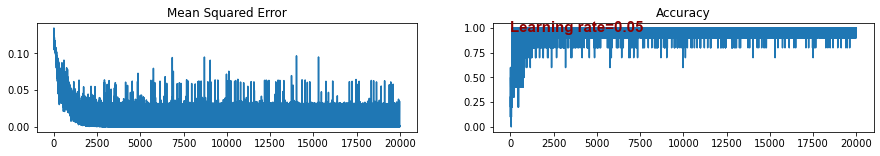

In [25]:
np.random.seed(3)
model = NeuralNetwork(n_hidden=[4], epochs=2000,learning_rate=0.08)
monitor=model.fit(X_train,y_train,momentum=True,momentum_Factor=0.9)   
y_hat = model.predict(X_test)
acc=model.accuracy(y_hat,y_test)
plot_acc_msa_with_epochs(monitor)
print(acc)

In [26]:
# plot_TT_Curves(X,y,model)


# Use  backpropagation algorithm on the Vowel data 

## Upload and prepare data

In [27]:
np.random.seed(0)
Vowel_Data=pd.read_csv('dataset_58_vowel.csv')
Vowel_Data=Vowel_Data.drop(["Train_or_Test","Speaker_Number"],axis=1)
Vowel_Data.tail(5)

,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
985,Female,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147,hOd
986,Female,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301,hod
987,Female,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500,hUd
988,Female,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390,hud
989,Female,-3.291,2.324,-0.679,0.285,0.441,0.557,-0.227,0.115,-1.046,0.697,hed


In [28]:
for i,row in Vowel_Data.iterrows():
    if row['Sex'] == 'Male' :
        Vowel_Data.at[i,'Sex'] = 0
    else  :
        Vowel_Data.at[i,'Sex'] = 1  

In [29]:
Vowel_Data.tail(2)

,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
988,1,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390,hud
989,1,-3.291,2.324,-0.679,0.285,0.441,0.557,-0.227,0.115,-1.046,0.697,hed


In [30]:
y_V=pd.get_dummies(Vowel_Data.Class).values
X_V=Vowel_Data.drop(["Class"],axis=1).values

## Split data 75/25

In [31]:
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X, y, test_size=0.25,random_state=42)

## Use single hidden layer For vowel Data 

0.9736842105263158


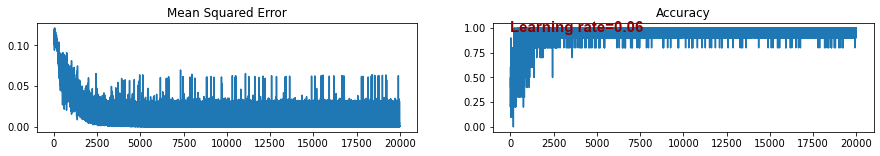

In [15]:
model_vowel = NeuralNetwork(n_hidden=[4], epochs=2000,learning_rate=0.05)
monitor_v=model_vowel.fit(X_train_v,y_train_v,momentum=True,momentum_Factor=0.9)   
y_hat_v = model_vowel.predict(X_test_v)
acc_v=model.accuracy(y_hat_v,y_test_v)
plot_acc_msa_with_epochs(monitor_v)
print(acc_v)

In [16]:
# plot_TT_Curves(X_V,y_V,model_vowel)

## Use 2-hidden layer For vowel Data 

0.9473684210526315


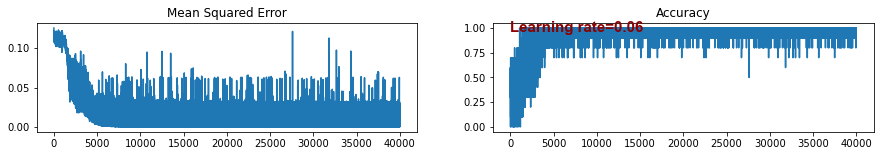

In [17]:
model_vowel_2 = NeuralNetwork(n_hidden=[6,4], epochs=4000,learning_rate=0.05)
monitor_v_2=model_vowel_2.fit(X_train_v,y_train_v,momentum=True,momentum_Factor=0.9)   
y_hat_v_2 = model_vowel_2.predict(X_test_v)
acc_v_2=model.accuracy(y_hat_v_2,y_test_v)
plot_acc_msa_with_epochs(monitor_v_2)
print(acc_v_2)